## Description

This Jupyter Notebook is designed to create a continuous spatial distribution map for Copper (Cu) and Cobalt (Co) concentrations using data from a CSV file. The dataset includes the concentrations of Cu and Co in various units, along with their corresponding geographic coordinates.

### Features:
- Load and process CSV data containing Cu and Co concentration values and their coordinates.
- Generate continuous spatial distribution maps for Cu and Co concentrations.
- Visualize the spatial variation of Cu and Co concentrations across the study area.

#### Version: 1.0
#### Date: 2024-06-14
#### Author: Ata Haddadi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import geopandas as gpd

from utility_function.interpolations_methods import interpolate_pnt_idw
from utility_function.raster_process import save_raster, imshow_raster
from utility_function.victor_process import find_minimum_rectangle_gdf, distance_nearest_neighbor_pnt

In [2]:
# load data and see the first  rows
path_file = "data/raw/soil_geochemistry.csv"
data = pd.read_csv(path_file)
data.head(10)

,Cu,Co,x,y,units
0,1005.545921,282.993340,99.901372,14.761337,ppm
1,867.986487,234.174761,55.263516,1.302959,ppm
2,96.807653,NaN,65.098168,85.424006,ppm
3,2.551491,0.346934,3.332742,72.062110,ppm
4,2374.160259,NaN,85.222209,25.060859,ppm
5,0.007068,0.001201,66.921381,97.873821,pct
6,0.005288,0.000676,67.398791,78.276039,pct
7,426.209268,70.920538,2.792840,35.296034,ppm
8,0.100882,0.011337,77.363267,76.113519,pct
9,3679.598922,721.787212,84.548477,63.849979,ppm


In [3]:
# summary and description of the data
print(data.describe())
print(data.isnull().sum(axis = 0))

                 Cu           Co           x           y
count    100.000000    70.000000  100.000000  100.000000
mean    1326.441381   123.422255   53.022683   47.992529
std     4095.181005   344.920968   29.568825   29.577223
min        0.000341     0.000041    0.239951    1.302959
25%        0.033853     0.003652   26.793476   21.825415
50%        1.977940     0.063725   58.244754   52.161900
75%      262.498224    25.253668   77.374387   73.305174
max    28546.476728  1856.614303   99.922557   99.030721
Cu        0
Co       30
x         0
y         0
units     0
dtype: int64


In [4]:
# if there are inf in the data
print(data[['x', 'y', 'Cu', 'Co']].isin([np.inf, -np.inf]).sum(axis=0))

x     0
y     0
Cu    0
Co    0
dtype: int64


Noticed that Co has null value (30 samples), units are different, distribtion is not normal

In [5]:
# 30% of the data for Co is null
data["Co_null"] = data.Co.isnull()
data.head(5)

,Cu,Co,x,y,units,Co_null
0,1005.545921,282.993340,99.901372,14.761337,ppm,False
1,867.986487,234.174761,55.263516,1.302959,ppm,False
2,96.807653,NaN,65.098168,85.424006,ppm,True
3,2.551491,0.346934,3.332742,72.062110,ppm,False
4,2374.160259,NaN,85.222209,25.060859,ppm,True


In [6]:
# Units are different, must to have one unit
def convert_pct_2_ppm(value, unit):
    if unit=="pct":
        return value*1e4
    return value

In [7]:
# Apply the conversion to the dataset and created new columns
data["Cu_ppm"] = data.apply(lambda x: convert_pct_2_ppm(x["Cu"], x["units"]), axis=1)
data["Co_ppm"] = data.apply(lambda x: convert_pct_2_ppm(x["Co"], x["units"]), axis=1)
data.head(5)

,Cu,Co,x,y,units,Co_null,Cu_ppm,Co_ppm
0,1005.545921,282.993340,99.901372,14.761337,ppm,False,1005.545921,282.993340
1,867.986487,234.174761,55.263516,1.302959,ppm,False,867.986487,234.174761
2,96.807653,NaN,65.098168,85.424006,ppm,True,96.807653,NaN
3,2.551491,0.346934,3.332742,72.062110,ppm,False,2.551491,0.346934
4,2374.160259,NaN,85.222209,25.060859,ppm,True,2374.160259,NaN


In [8]:
# point density in the region and area of the study
length_x = data.x.max() - data.x.min()
length_y = data.y.max() - data.y.min()

area_roi = length_x * length_y
pnt_density = data.shape[0] / area_roi
mean_distance_btw_pnt = (1/pnt_density)**0.5
print(f'area: {area_roi:1.2f}   - pnt_density: {pnt_density:1.2f} - mean distance btw points: {mean_distance_btw_pnt:1.2f}')

area: 9741.76   - pnt_density: 0.01 - mean distance btw points: 9.87


The folloing figures help to understand data more.

c:\Users\ahaddadi\AppData\Local\anaconda3\envs\geochem\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ahaddadi\AppData\Local\anaconda3\envs\geochem\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


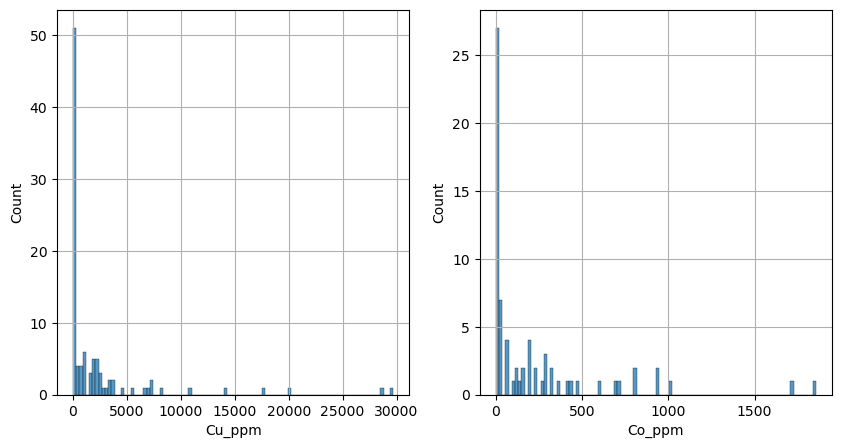

In [9]:
# plot histogram of the data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=data, x="Cu_ppm", bins=100)
plt.grid()
plt.subplot(1, 2, 2)
sns.histplot(data=data, x="Co_ppm", bins=100)
plt.grid()

There are 30 samples with Null values for Co. Before proceeding with further analysis, we need to address these Null values.
First, let's identify where the data is Null and analyze the spatial distribution of these Null values.
This will help us determine if the Null values are concentrated in a specific area.

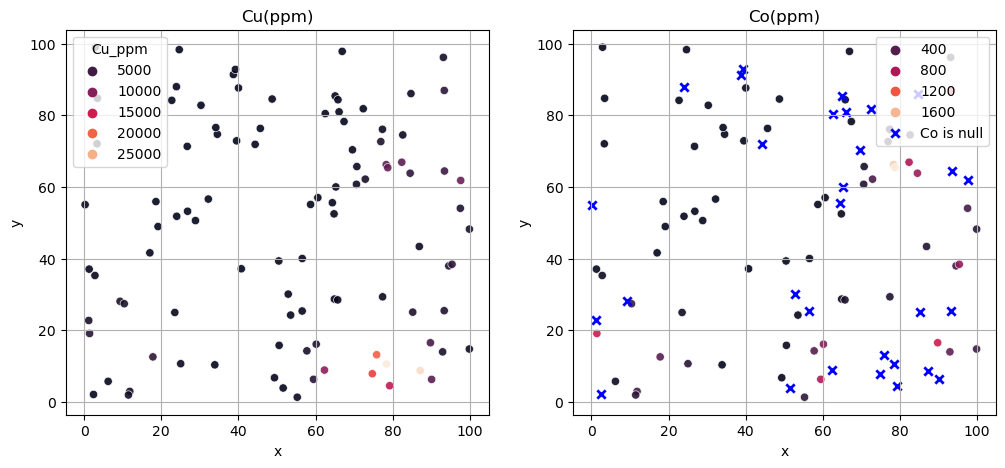

In [10]:
# plot spatial distribution of Cu and Co and where the data is missing
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x="x", y="y", hue="Cu_ppm", palette="rocket", alpha=0.9, legend="brief")
plt.title("Cu(ppm)")
plt.grid()

plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x="x", y="y", hue="Co_ppm", palette="rocket", alpha=0.9, legend="auto")

ind_null_co = data["Co_null"]
sns.scatterplot(data=data[ind_null_co], x="x", y="y", marker="x", color="b", label="Co is null", linewidth=2)
plt.legend()
plt.title("Co(ppm)")
plt.grid()
plt.show()

In [11]:
# Find correlation between data and plot to see if we can fill null value efficinetly
corr_matrix = data[["x", "y", "Cu_ppm", "Co_ppm"]].corr()
print(corr_matrix)

               x         y    Cu_ppm    Co_ppm
x       1.000000  0.028460  0.344991  0.389423
y       0.028460  1.000000 -0.343678 -0.118107
Cu_ppm  0.344991 -0.343678  1.000000  0.934608
Co_ppm  0.389423 -0.118107  0.934608  1.000000


Based on the correlation matrix, I hypothesize that we can predict Co when its value is missing. I tested models based on KNN and linear regression to fill in the missing Co values.

Text(0.5, 1.0, 'Cu vs Co')

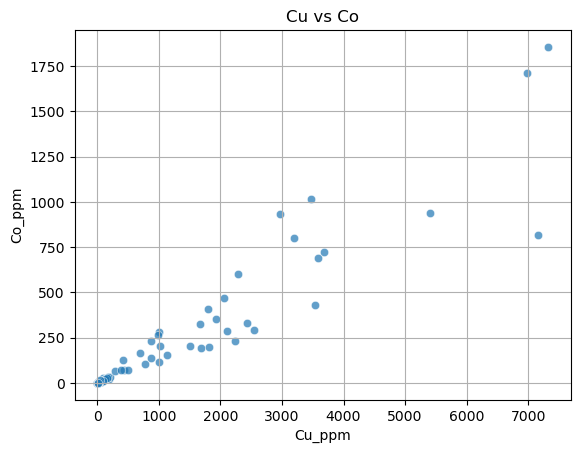

In [12]:
sns.scatterplot(data=data, x="Cu_ppm", y="Co_ppm", alpha=0.7)
plt.grid()
plt.title("Cu vs Co")

In [13]:
# Apply KNN model to fill Null value in Co
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

In [14]:
# Prepare the features (x, y, Cu) and target (Co) for training
ind_null_co = data["Co_null"]

x_features = ["x", "y", "Cu_ppm"]
X = data[x_features][~ind_null_co]
y = data[["Co_ppm"]][~ind_null_co]

X_Co_null = data[x_features][ind_null_co]

# Train KNN model and predict Null values of Co
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X, y)

y_pred = knn.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

predicted_Co = knn.predict(X_Co_null)
# update null values
data.loc[ind_null_co, "Co_ppm"] = predicted_Co.reshape((-1))

Mean Squared Error: 23993.65050881819
R2 Score: 0.8272676492203572


Text(0.5, 1.0, 'Cu vs Co')

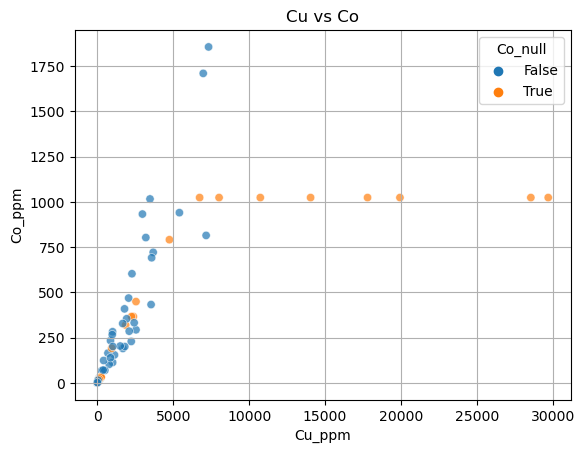

In [15]:
# scatterplot of the Cu vs Co
sns.scatterplot(data=data, x="Cu_ppm", y="Co_ppm", hue="Co_null", alpha=0.7)
plt.grid()
plt.title("Cu vs Co")

In [16]:
#2 Apply linear model to predict Co
x_features = ["x", "y", "Cu_ppm"]
X = data[x_features][~ind_null_co]
y = data[["Co_ppm"]][~ind_null_co]

X_Co_null = data[x_features][ind_null_co]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# update null values and adjust the value to 0 if it is negetive
predicted_Co = linear_model.predict(X_Co_null)
predicted_Co[predicted_Co<0] = 0
data.loc[ind_null_co, "Co_ppm"] = predicted_Co.reshape((-1))

Mean Squared Error: 18383.757687991205
R2 Score: 0.913587802623895


Text(0.5, 1.0, 'Co prediction using linear model Co=f(x, y, Cu)')

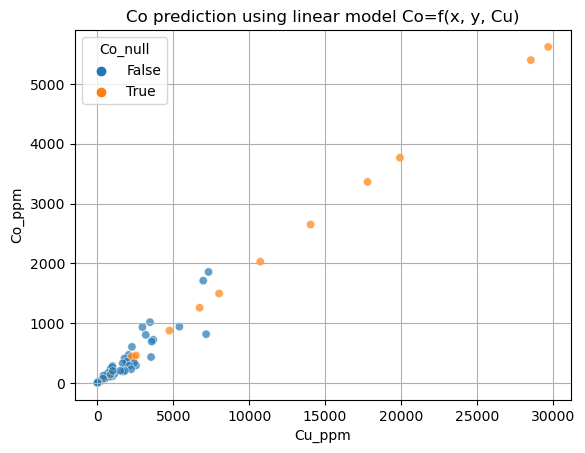

In [17]:
# scatterplot of the Cu vs Co
sns.scatterplot(data=data, x="Cu_ppm", y="Co_ppm", hue="Co_null", alpha=0.7)
plt.grid()
plt.title("Co prediction using linear model Co=f(x, y, Cu)")

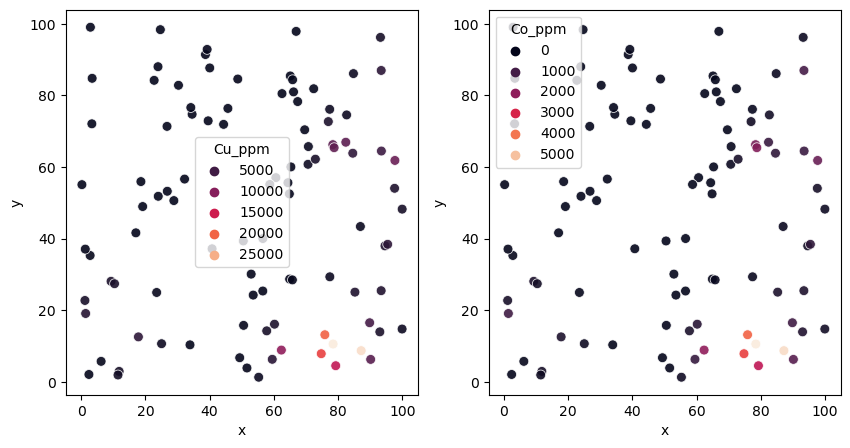

In [18]:
# replot the scatter plot for Cu_ppm and Co_ppm
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x="x", y="y", hue="Cu_ppm", palette="rocket", s=50, alpha=0.9)
plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x="x", y="y", hue="Co_ppm", palette="rocket", s=50, alpha=0.9)
plt.show()

In [19]:
# save data in geojson for further analysis
data_geometry = gpd.points_from_xy(data.x, data.y)
data_gdf = gpd.GeoDataFrame(data, geometry=data_geometry, crs="EPSG:3857")

# save data without null values
data.to_csv("data/processed/cu_co_without_Null.csv", index=False)

# save the geodatafram
data_gdf.to_file("data/processed/cu_co_without_Null_gdf.geojson")

In [20]:
print(mean_distance_btw_pnt)

9.870034454760628


In [21]:
# find the distance between each point and its closes point 
data_gdf["nearest_dist"] = distance_nearest_neighbor_pnt(data_gdf)
data_gdf.to_file("data/processed/cu_co_without_Null_gdf_dist.geojson")
data_gdf.head(2)

,Cu,Co,x,y,units,Co_null,Cu_ppm,Co_ppm,geometry,nearest_dist
0,1005.545921,282.993340,99.901372,14.761337,ppm,False,1005.545921,282.993340,POINT (99.901 14.761),6.971703
1,867.986487,234.174761,55.263516,1.302959,ppm,False,867.986487,234.174761,POINT (55.264 1.303),4.473198


count    100.000000
mean       5.034999
std        3.273174
min        0.889245
25%        3.050798
50%        3.996993
75%        6.469695
max       17.268317
Name: nearest_dist, dtype: float64


c:\Users\ahaddadi\AppData\Local\anaconda3\envs\geochem\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


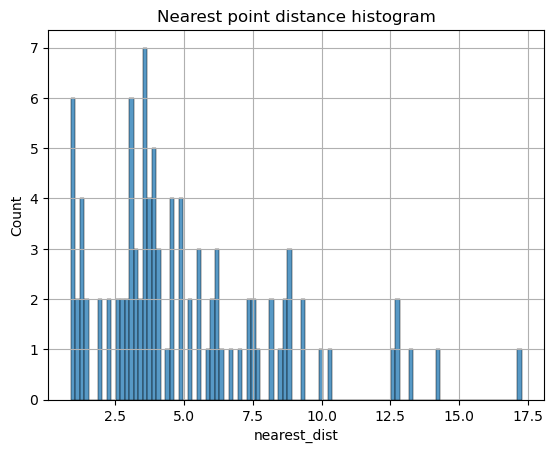

In [22]:
# plot the distribution of the distance
print(data_gdf["nearest_dist"].describe())
sns.histplot(data=data_gdf, x="nearest_dist", bins=100)
plt.title("Nearest point distance histogram")
plt.grid()
plt.show()

In [23]:
print(pnt_density)
print(mean_distance_btw_pnt)

0.010265087662634974
9.870034454760628


The point density is 0.1, and the mean distance between points is 9.9. Depending on the homogeneity of the selected points for sampling, the cell size can be defined. For this example, I chose a cell size of 1 because data collection is expensive, and I want to avoid having too many points within a single cell. Based on the minimum box, a boundary was created for the data. Additionally, a buffer based on the average distance between points (5) was considered to ensure all points are within the boundary

In [24]:
data_gdf = data_gdf[["Cu_ppm", "Co_ppm", "Co_null", "x", "y", "geometry"]]
data_gdf.to_file("data/outputs/pnt_cu_co.geojson")

bnd_gdf = find_minimum_rectangle_gdf(data_gdf, buffer=5)
bnd_gdf.to_file("data/outputs/bnd.geojson")

To create a 2D map of the concentration, there are several options, I found best results in IDW with the weight distance coef: 3

In [25]:
# interpolation of Cu based on IDW
buffer = 5
cell_size = 0.5
distance_coef = 3.
path_save_img_cu = "data/outputs/cu_idw_3.tif"
cu_raster = interpolate_pnt_idw(data_gdf, "Cu_ppm", cell_size=cell_size, distance_coef=distance_coef, buffer=buffer)
save_raster(cu_raster, path_save_img_cu)

# interpolation of Co based on IDW
path_save_img_cu = "data/outputs/co_idw_3.tif"
co_raster = interpolate_pnt_idw(data_gdf, "Co_ppm", cell_size=cell_size, distance_coef=distance_coef, buffer=buffer)
save_raster(co_raster, path_save_img_cu)

c:\Users\ahaddadi\AppData\Local\anaconda3\envs\geochem\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(200, 'raster was saved')

Visulize final images

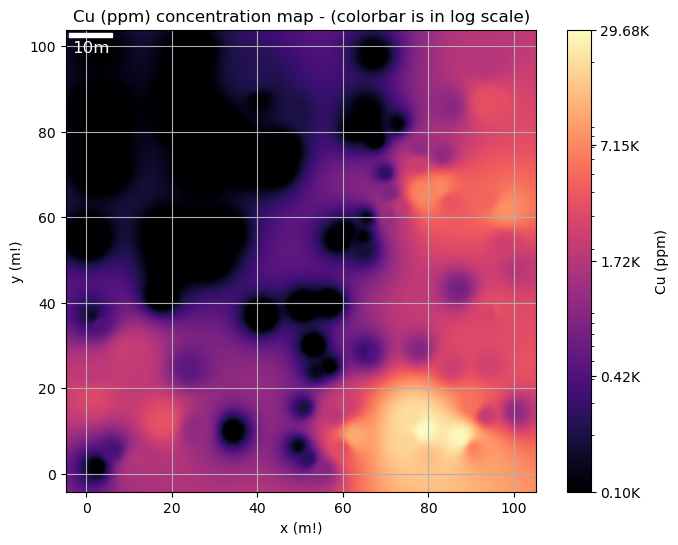

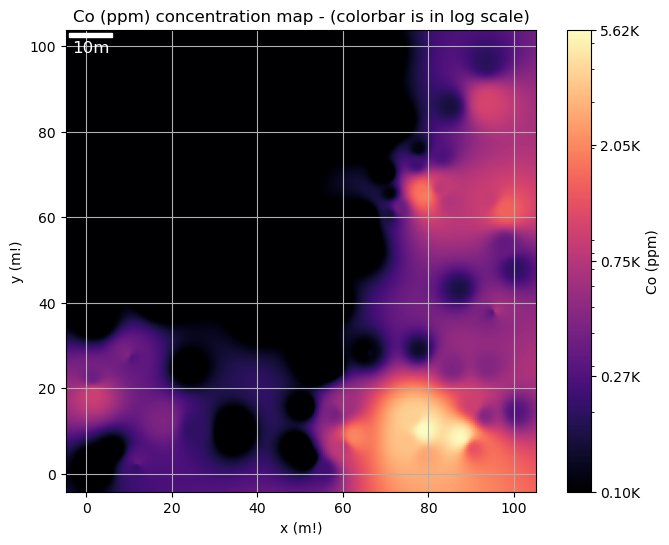

In [26]:
# plot the final images
cu_img = cu_raster['Image']
GeoT_im = cu_raster['GeoT_im'] 

imshow_raster(cu_raster, name='Cu (ppm)', cmap='magma')
plt.savefig('result_images\cu_map.png')

co_img = co_raster['Image']
imshow_raster(co_raster, name='Co (ppm)', cmap='magma')
plt.savefig('result_images\co_map.png')